## Introduction
Greetings from the Kaggle bot! This is an automatically-generated kernel with starter code demonstrating how to read in the data and begin exploring. Click the blue "Edit Notebook" or "Fork Notebook" button at the top of this kernel to begin editing.

## Exploratory Analysis
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data. Depending on the data, not all plots will be made. (Hey, I'm just a kerneling bot, not a Kaggle Competitions Grandmaster!)

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra||
import os # accessing directory structre
import pandas as pd # data processing, CSV file \I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch.nn as nn
import tqdm

There is 1 csv file in the current version of the dataset:


In [2]:
# print(os.listdir('../input'))

The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [70]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [71]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: ../input/PS_20174392719_1491204439457_log.csv

In [72]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


def exclude_current_meanDest(row):
  """
  Function that calculates mean of dest account excluding the current transaction
  """
  num_transactions = row['num_transDest']
  mean = row['meanDest']

  # if there is only 1 transaction, return current mean
  if num_transactions == 1:
    return mean
  
  amount = row['amount']
  return ((mean*num_transactions) - amount) / (num_transactions - 1)


def exclude_current_meanOrig(row):
  """
  Function that calculates mean of orig account excluding the current transaction
  """
  num_transactions = row['num_transOrig']
  mean = row['meanOrig']

  # if there is only 1 transaction, return current mean
  if num_transactions == 1:
    return mean

  amount = row['amount']
  return ((mean*num_transactions) - amount) / (num_transactions - 1)


def exclude_current_maxDest(row, df):
  """
  Function that calculates max of dest account excluding the current transaction
  """
  current_max = row['maxDest']
  amount = row['amount']
  transactions = row['num_transDest']
  
  if current_max == amount:
    if transactions > 1:
      # Find the maximum amount excluding the current transaction
      max_exclude_current = df.loc[(df['nameDest'] == row['nameDest']) & (df['amount'] != amount), 'amount'].max()
      if pd.notna(max_exclude_current):
        return max_exclude_current
  return current_max

def exclude_current_maxOrig(row, df):
  """
  Function that calculates max of orig account excluding the current transaction
  """
  current_max = row['maxOrig']
  amount = row['amount']
  transactions = row['num_transOrig']
  
  if current_max == amount:
    if transactions > 1:
      # Find the maximum amount excluding the current transaction
      max_exclude_current = df.loc[(df['nameOrig'] == row['nameOrig']) & (df['amount'] != amount), 'amount'].max()
      if pd.notna(max_exclude_current):
        return max_exclude_current
  return current_max

In [73]:
nRowsRead = 260_000# specify 'None' if want to read whole file
# PS_20174392719_1491204439457_log.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('paysim.csv', delimiter=',', nrows = nRowsRead)
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})

# if oldBalance = newBalance = 0, account is likely from external institution
df['externalDest'] = ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0)).astype(int)
df['externalOrig'] = ((df['oldbalanceOrig'] == 0) & (df['newbalanceOrig'] == 0)).astype(int)

# Update the values in the 'newbalanceDest' column to 'oldbalanceDest +- amount'
df['newbalanceDest'] = df['oldbalanceDest'] + df['amount']
df['oldbalanceOrig'] = df['newbalanceOrig'] + df['amount']


""" Feature Engineering """

# gaussian noise std
num_transactions = df.shape[0]
std = 0.01*(df['amount'].quantile(0.75) - df['amount'].min())

# calculate the overall mean of both the destination and origin account (excluding current transaction) and add noise
noise = np.random.normal(0, std, num_transactions)
df['num_transDest'] = df.groupby('nameDest')['nameDest'].transform('count')
df['meanDest'] = df.groupby('nameDest')['amount'].transform('mean')
df['meanDest'] = df.apply(exclude_current_meanDest, axis=1)
df['meanDest'] += noise

noise = np.random.normal(0, std, num_transactions)
df['num_transOrig'] = df.groupby('nameOrig')['nameOrig'].transform('count')
df['meanOrig'] = df.groupby('nameOrig')['amount'].transform('mean')
df['meanOrig'] = df.apply(exclude_current_meanOrig, axis=1)
df['meanOrig'] += noise

# swap places for consistency
num_transDest = df.pop('num_transDest')
df['num_transDest'] = num_transDest
num_transOrig = df.pop('num_transOrig')
df['num_transOrig'] = num_transOrig

# calculate the overall max of both the destination and origin account (excluding current transaction) and add noise
noise = np.random.normal(0, std, num_transactions)
df['maxDest'] = df.groupby('nameDest')['amount'].transform('max')
df['maxDest'] = df.apply(lambda x: exclude_current_maxDest(x, df), axis=1)
df['maxDest'] += noise

noise = np.random.normal(0, std, num_transactions)
df['maxOrig'] = df.groupby('nameOrig')['amount'].transform('max')
df['maxOrig'] = df.apply(lambda x: exclude_current_maxOrig(x, df), axis=1)
df['maxOrig'] += noise

# sort the values according to timestep
df = df.sort_values('step')

# calculate the rolling average of last 3 and 7 transactions for each recipient
df['meanDest3'] = df.groupby('nameDest')['amount'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df['meanDest7'] = df.groupby('nameDest')['amount'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)

# calculate the rolling maximum of last 3 and 7 transactions for each recipient
df['maxDest3'] = df.groupby('nameDest')['amount'].rolling(window=3, min_periods=1).max().reset_index(0, drop=True)
df['maxDest7'] = df.groupby('nameDest')['amount'].rolling(window=7, min_periods=1).max().reset_index(0, drop=True)

# rearrange column order
df = df.reindex(columns=[col for col in df.columns if col not in ['num_transDest', 'num_transOrig', 'externalDest', 'externalOrig', 'isFraud']] + ['num_transDest', 'num_transOrig', 'externalDest', 'externalOrig', 'isFraud'])


""" Prepare the training and test sets """

# delete name columns that will not be used
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

# split the dataset into training and validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)
val_set_size = 0.10/0.25
test_df, val_df = train_test_split(test_df, test_size=val_set_size, random_state=42, shuffle=True)

# reset index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# remove non numerical columns of training set and save for later
type_col = train_df.pop('type')
num_transDest_col = train_df.pop('num_transDest')
num_transOrig_col = train_df.pop('num_transOrig')
externalDest_col = train_df.pop('externalDest')
externalOrig_col = train_df.pop('externalOrig')
isFraud_col = train_df.pop('isFraud')

print('start fitting scaler')
# fit the scaler on the train data and transform
scaler = StandardScaler()
scaler = scaler.fit(train_df)
print('done fitting scaler')
train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)

# add the non numerical columns back
train_df = pd.concat([train_df, type_col, num_transDest_col, num_transOrig_col, externalDest_col, externalOrig_col, isFraud_col], axis=1)

# do the same on the test set, use the scaler fit on the train set
type_col = test_df.pop('type')
num_transDest_col = test_df.pop('num_transDest')
num_transOrig_col = test_df.pop('num_transOrig')
externalDest_col = test_df.pop('externalDest')
externalOrig_col = test_df.pop('externalOrig')
isFraud_col = test_df.pop('isFraud')
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
test_df = pd.concat([test_df, type_col, num_transDest_col, num_transOrig_col, externalDest_col, externalOrig_col, isFraud_col], axis=1)

# do the same on the val set, use the scaler fit on the train set
type_col = val_df.pop('type')
num_transDest_col = val_df.pop('num_transDest')
num_transOrig_col = val_df.pop('num_transOrig')
externalDest_col = val_df.pop('externalDest')
externalOrig_col = val_df.pop('externalOrig')
isFraud_col = val_df.pop('isFraud')
val_df = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns)
val_df = pd.concat([val_df, type_col, num_transDest_col, num_transOrig_col, externalDest_col, externalOrig_col, isFraud_col], axis=1)

# one-hot encode the 'type' column
train_df = pd.get_dummies(train_df, columns=['type'],  dtype=int)
test_df = pd.get_dummies(test_df, columns=['type'],  dtype=int)
val_df = pd.get_dummies(val_df, columns=['type'],  dtype=int)

# move the 'isFraud' column to the end of the dataframe
is_fraud_col = train_df.pop('isFraud')
train_df['isFraud'] = is_fraud_col

is_fraud_col = test_df.pop('isFraud')
test_df['isFraud'] = is_fraud_col

is_fraud_col = val_df.pop('isFraud')
val_df['isFraud'] = is_fraud_col


# save the train, validation and test set
# train_df.to_csv("./train_df_nb.csv",)
# test_df.to_csv("./test_df_nb.csv",)
# val_df.to_csv("./val_df_nb.csv",)


start fitting scaler
done fitting scaler


Let's take a quick look at what the data looks like:

In [13]:
train_df = pd.read_csv('train_df.csv').iloc[:1_500_000]
test_df = pd.read_csv('test_df.csv').iloc[:300_000]
val_df = pd.read_csv('val_df.csv').iloc[:300_000]








In [14]:
train_df['isFraud'].value_counts()

isFraud
0    499408
1       592
Name: count, dtype: int64

In [15]:
import sys
import os



# Add the path to your KAN module
sys.path.append(os.path.abspath('/Users/barager/Desktop/symbolic classifciation/kan'))

from kan.KAN import *

import torch


Distribution graphs (histogram/bar graph) of sampled columns:

In [16]:
# train_df = train_df.iloc[:10000]
# val_df = val_df.iloc[:5000]
# test_df = test_df.iloc[:5000]

print(train_df['isFraud'].value_counts())
print(val_df['isFraud'].value_counts())
print(test_df['isFraud'].value_counts())

train_df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = train_df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)
val_df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = val_df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)
test_df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = test_df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)



X, y = train_df[[ 'amount',  'externalDest', 'externalOrig', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', ]], train_df['isFraud']


X_val, y_val = val_df[[ 'amount',  'externalDest', 'externalOrig', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', ]], val_df['isFraud']

X_test, y_test = test_df[['amount',  'externalDest', 'externalOrig', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', ]], test_df['isFraud']

# train_df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
#          'oldbalanceDest', 'newbalanceDest', 'meanDest', 'meanOrig', 'maxDest',
#          'maxOrig', 'meanDest3', 'meanDest7', 'maxDest3', 'maxDest7',
        #  'num_transDest', 'num_transOrig', 'externalDest', 'externalOrig','type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',]], train_df['isFraud']

# val_df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
#          'oldbalanceDest', 'newbalanceDest', 'meanDest', 'meanOrig', 'maxDest',
#          'maxOrig', 'meanDest3', 'meanDest7', 'maxDest3', 'maxDest7',
        #  'num_transDest', 'num_transOrig', 'externalDest', 'externalOrig','type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',]], val_df['isFraud']


# test_df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
#          'oldbalanceDest', 'newbalanceDest', 'meanDest', 'meanOrig', 'maxDest',
#          'maxOrig', 'meanDest3', 'meanDest7', 'maxDest3', 'maxDest7',
        #  'num_transDest', 'num_transOrig', 'externalDest', 'externalOrig','type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',]], test_df['isFraud']


def count_parameters(model):
                return sum(p.numel() for p in model.parameters() if p.requires_grad)

            
# Prepare the dataset dictionary
dataset = {
    'train_input': torch.tensor(X.values, dtype=torch.float64),
    'train_label': torch.tensor(y.values, dtype=torch.float64),
    'test_input': torch.tensor(X_val.values, dtype=torch.float64),
    'test_label': torch.tensor(y_val.values, dtype=torch.float64)
}



isFraud
0    499408
1       592
Name: count, dtype: int64
isFraud
0    199757
1       243
Name: count, dtype: int64
isFraud
0    199724
1       276
Name: count, dtype: int64


In [17]:
X.columns

Index(['amount', 'externalDest', 'externalOrig', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [18]:
model = KAN(width=[len(X.columns),1,1,1,1,1,1,2], grid=2, k=3)
print(f"KAN parameters: {count_parameters(model)}")
dataset['train_label'] = dataset['train_label'].long()
dataset['test_label'] = dataset['test_label'].long()


def train_f1_score():
    predictions = torch.argmax(model(dataset['train_input']), dim=1)
    true_labels = dataset['train_label']
    
    true_positives = ((predictions == 1) & (true_labels == 1)).sum().float()
    predicted_positives = (predictions == 1).sum().float()
    actual_positives = (true_labels == 1).sum().float()
    
    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    # print(f'Train F1 Score: {f1:.3f}')
    return f1

def test_f1_score():
    predictions = torch.argmax(model(dataset['test_input']), dim=1)
    true_labels = dataset['test_label']
    
    true_positives = ((predictions == 1) & (true_labels == 1)).sum().float()
    predicted_positives = (predictions == 1).sum().float()
    actual_positives = (true_labels == 1).sum().float()
    
    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    # print(f'Test F1 Score: {f1:.3f}')
    return f1

targets = dataset['train_label']
class_counts = torch.bincount(targets)
total_samples = len(targets)
class_weights = (total_samples / (2 * class_counts)).double()
loss_fn = nn.CrossEntropyLoss()
# batch_size = 10_000

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_f1_score, test_f1_score), lr=0.1, loss_fn=loss_fn,)

KAN parameters: 173


train loss: 5.54e-02 | test loss: 5.57e-02 | train f1: 0.774 | test f1: 0.788 | lr: 1.00e-01 : 100%|████████| 20/20 [16:37<00:00, 49.90s/it]


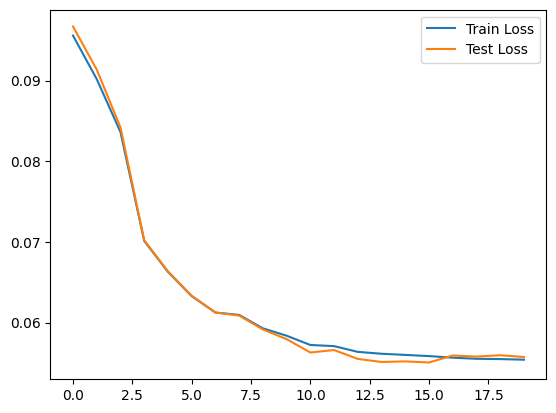

In [22]:
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.legend()
plt.show()

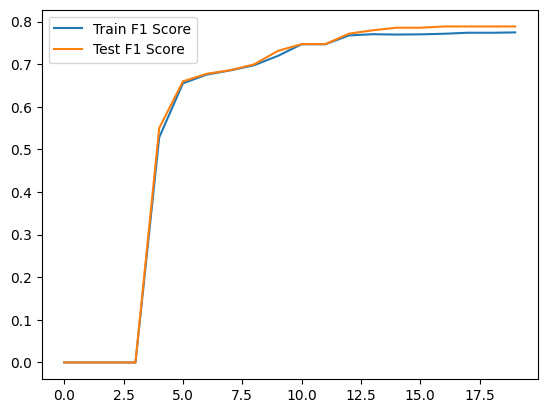

In [23]:
# fig = plt.figure(xlabel='Epoch', ylabel='F1 Score')
plt.plot(results['train_f1_score'], label='Train F1 Score')
plt.plot(results['test_f1_score'], label='Test F1 Score')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import classification_report, accuracy_score
test_dataset = {
    'test_input': torch.tensor(X_test.values, dtype=torch.float64),
    'test_label': torch.tensor(y_test.values, dtype=torch.float64)
}


y_pred = torch.argmax(model(test_dataset['test_input']), dim=1).numpy()
y_true = test_dataset['test_label'].numpy()
print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    199724
         1.0       0.98      0.67      0.80       276

    accuracy                           1.00    200000
   macro avg       0.99      0.84      0.90    200000
weighted avg       1.00      1.00      1.00    200000

0.999525


59.96*sqrt(1 - 0.94*sqrt(0.1*sqrt(1 - x_2) - 0.55*sqrt(1 - 1.0*x_3) - 0.2*sqrt(1 - 1.0*x_4) + 0.6*sqrt(1 - 1.0*x_5) - 0.01*sqrt(1 - x_6) - 0.34*sqrt(1 - 1.0*x_7) + 0.08*sqrt(1 - x_8) + 1)) - 36.05

In [46]:
model.prune()
print("Model pruned")
lib = ['x', 'x^2','sqrt']
model.auto_symbolic(lib=lib)
formula1, formula2 = model.symbolic_formula()[0]

Model pruned
fixing (0,0,0) with x, r2=0.9999999999645587
fixing (0,1,0) with x^2, r2=0.9999999999999263
fixing (0,2,0) with x^2, r2=0.9999999999999987
fixing (0,3,0) with x^2, r2=0.9999999999999678
fixing (0,4,0) with x^2, r2=0.9999999999999989
fixing (0,5,0) with x^2, r2=0.9999999948521093
fixing (0,6,0) with x^2, r2=0.9999999999999948
fixing (0,7,0) with x^2, r2=0.9999999999989779


ValueError: Input y contains NaN.

In [50]:
# Define the function to compute the equation
def compute_equation1(row):
    x2 = row['meanOrig']
    x3 = row['maxDest']
    x4 = row['meanDest3']
    x5 = row['meanDest7']
    x6 = row['num_transDest']
    x7 = row['num_transOrig']
    x8 = row['externalDest']

    inner_expression = (0.1 * np.sqrt(1 - x2) - 
                        0.55 * np.sqrt(1 - x3) - 
                        0.2 * np.sqrt(1 - x4) + 
                        0.6 * np.sqrt(1 - x5) - 
                        0.01 * np.sqrt(1 - x6) - 
                        0.34 * np.sqrt(1 - x7) + 
                        0.08 * np.sqrt(1 - x8) + 1)

    result = 28.7 - 16.23 * np.sqrt(1 - 0.96 * np.sqrt(inner_expression))

    return 1 if result > 0.9999 else 0

# Example usage
# Assuming 'val_df' is your DataFrame and it has a column 'isFraud'
# Let's create a sample DataFrame to simulate 'val_df'

# Sample DataFrame
val_df = test_df.copy()

# Calculate the results for all rows
val_df['computed_result'] = val_df.apply(compute_equation1, axis=1)

# Extract the true labels and predicted labels
y_true = val_df['isFraud']
y_pred = val_df['computed_result']


from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Output the DataFrame to check the results
# print(val_df)


/var/folders/3g/cfx5dwyj6vs289v_k3y0jmtw0000gn/T/ipykernel_49987/3983253669.py:15: RuntimeWarning: invalid value encountered in sqrt
  0.01 * np.sqrt(1 - x6) -
/var/folders/3g/cfx5dwyj6vs289v_k3y0jmtw0000gn/T/ipykernel_49987/3983253669.py:13: RuntimeWarning: invalid value encountered in sqrt
  0.2 * np.sqrt(1 - x4) +
/var/folders/3g/cfx5dwyj6vs289v_k3y0jmtw0000gn/T/ipykernel_49987/3983253669.py:12: RuntimeWarning: invalid value encountered in sqrt
  0.55 * np.sqrt(1 - x3) -
/var/folders/3g/cfx5dwyj6vs289v_k3y0jmtw0000gn/T/ipykernel_49987/3983253669.py:11: RuntimeWarning: invalid value encountered in sqrt
  inner_expression = (0.1 * np.sqrt(1 - x2) -
/var/folders/3g/cfx5dwyj6vs289v_k3y0jmtw0000gn/T/ipykernel_49987/3983253669.py:14: RuntimeWarning: invalid value encountered in sqrt
  0.6 * np.sqrt(1 - x5) -
/var/folders/3g/cfx5dwyj6vs289v_k3y0jmtw0000gn/T/ipykernel_49987/3983253669.py:16: RuntimeWarning: invalid value encountered in sqrt
  0.34 * np.sqrt(1 - x7) +


Accuracy: 0.64671
Precision: 0.0007377979568671964
Recall: 0.18439716312056736
F1 Score: 0.001469715383963144


In [ ]:
def compute_equation(row):
    x2 = row['meanOrig']
    x3 = row['maxDest']
    x4 = row['meanDest3']
    x5 = row['meanDest7']
    x6 = row['num_transDest']
    x7 = row['num_transOrig']
    x8 = row['externalDest']

    inner_expression = (0.1 * np.sqrt(1 - x2) - 
                        0.55 * np.sqrt(1 - x3) - 
                        0.2 * np.sqrt(1 - x4) + 
                        0.6 * np.sqrt(1 - x5) - 
                        0.01 * np.sqrt(1 - x6) - 
                        0.34 * np.sqrt(1 - x7) + 
                        0.08 * np.sqrt(1 - x8) + 1)

    result = 28.7 - 16.23 * np.sqrt(1 - 0.96 * np.sqrt(inner_expression))

    return 1 if result > 0 else 0


compute_equation(train_df.iloc[0])





: 

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Configure classifiers
rfc = RandomForestClassifier(n_estimators=20, max_depth=5)
dtc = DecisionTreeClassifier(max_depth=5)
logreg = LogisticRegression(max_iter=500, penalty='l2', solver='lbfgs')
nb = GaussianNB()
xgboost = XGBClassifier()

classifiers = [rfc, dtc, logreg, nb, xgboost]
classifier_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'GaussianNB', 'XGBClassifier']

# Number of runs
k = 10

# Dictionary to store metrics
metrics = {name: {'precision': [], 'recall': [], 'f1': [], 'accuracy': []} for name in classifier_names}

# Run each classifier k times
for i in range(k):
    for classifier, name in zip(classifiers, classifier_names):
        classifier.fit(X, y)
        y_pred = classifier.predict(X_test)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        accuracy = accuracy_score(y_test, y_pred)
        metrics[name]['precision'].append(precision)
        metrics[name]['recall'].append(recall)
        metrics[name]['f1'].append(f1)
        metrics[name]['accuracy'].append(accuracy)

        if i == k - 1:  # Only print the report on the last iteration
            print(name)
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            print()

# Calculate average and variance for each metric for each classifier
for name in classifier_names:
    avg_precision = np.mean(metrics[name]['precision'])
    var_precision = np.var(metrics[name]['precision'])
    avg_recall = np.mean(metrics[name]['recall'])
    var_recall = np.var(metrics[name]['recall'])
    avg_f1 = np.mean(metrics[name]['f1'])
    var_f1 = np.var(metrics[name]['f1'])
    avg_accuracy = np.mean(metrics[name]['accuracy'])
    var_accuracy = np.var(metrics[name]['accuracy'])

    print(f'{name} - Average Precision: {avg_precision:.4f}, Variance Precision: {var_precision:.4f}')
    print(f'{name} - Average Recall: {avg_recall:.4f}, Variance Recall: {var_recall:.4f}')
    print(f'{name} - Average F1 Score: {avg_f1:.4f}, Variance F1 Score: {var_f1:.4f}')
    print(f'{name} - Average Accuracy: {avg_accuracy:.4f}, Variance Accuracy: {var_accuracy:.4f}')
    print()

RandomForestClassifier
Precision: 0.9736
Recall: 0.6974
F1 Score: 0.8127
Accuracy: 0.9995

DecisionTreeClassifier
Precision: 0.9641
Recall: 0.6974
F1 Score: 0.8093
Accuracy: 0.9995

LogisticRegression
Precision: 0.7333
Recall: 0.5461
F1 Score: 0.6260
Accuracy: 0.9991

GaussianNB
Precision: 0.0061
Recall: 0.9976
F1 Score: 0.0122
Accuracy: 0.7715

XGBClassifier
Precision: 0.9646
Recall: 0.7092
F1 Score: 0.8174
Accuracy: 0.9996

RandomForestClassifier - Average Precision: 0.9776, Variance Precision: 0.0001
RandomForestClassifier - Average Recall: 0.6095, Variance Recall: 0.0179
RandomForestClassifier - Average F1 Score: 0.7401, Variance F1 Score: 0.0136
RandomForestClassifier - Average Accuracy: 0.9994, Variance Accuracy: 0.0000

DecisionTreeClassifier - Average Precision: 0.9641, Variance Precision: 0.0000
DecisionTreeClassifier - Average Recall: 0.6974, Variance Recall: 0.0000
DecisionTreeClassifier - Average F1 Score: 0.8093, Variance F1 Score: 0.0000
DecisionTreeClassifier - Average A

In [140]:



# X_test  = test_df.drop('isFraud', axis=1)
# X_test[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = X_test[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)
# y_test = test_df['isFraud']



RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299577
           1       0.98      0.60      0.74       423

    accuracy                           1.00    300000
   macro avg       0.99      0.80      0.87    300000
weighted avg       1.00      1.00      1.00    300000

Accuracy: 0.99941

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299577
           1       0.96      0.70      0.81       423

    accuracy                           1.00    300000
   macro avg       0.98      0.85      0.90    300000
weighted avg       1.00      1.00      1.00    300000

Accuracy: 0.9995366666666666

LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299577
           1       0.73      0.55      0.63       423

    accuracy                           1.00    300000
   macro avg  

In [55]:
from torch.utils.data import DataLoader, TensorDataset
import torch


# Assuming X, y, x_val, y_val, x_test, y_test are pandas dataframes
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

x_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoadrs
batch_size = 2000

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [108]:
class CNN(nn.Module):
    def __init__(self, input_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * input_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Example usage
input_dim = X.shape[1]  # Set this to the number of features in your dataset
cnn = CNN(input_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.hidden_size = hidden_size

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.hidden_size = hidden_size
        
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h_0, c_0))
        out = out[:, -1, :]
        out = self.sigmoid(self.fc(out))
        return out
    
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.sigmoid(self.fc(x))
        return x
    

# Assuming the LSTM model and other components are defined as in previous examples
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out
    
class AttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AttentionModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.hidden_size = hidden_size

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0),self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        out = self.sigmoid(out)
        return out
    
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 1, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x



    
# Example usage
input_dim = X.shape[1]
hidden_dim = 32
num_layers = 2
gru = GRU(input_dim, hidden_dim, num_layers)
rnn = RNN(input_dim, hidden_dim, num_layers)
am = AttentionModel(input_dim, hidden_dim, num_layers)
dcnn = DeepCNN()

snn = SimpleNN(input_dim)
transformer = TransformerModel(input_dim, hidden_dim, num_layers, num_layers)

In [144]:
# Number of runs
k = 10

# Lists to store results
test_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for i in range(k):
    print(f'Run {i+1}/{k}')
    
    # Train the model
    train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    
    # Test the model
    test_loss, accuracy, report = test(cnn, test_loader, criterion)
    
    # Store results
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    precisions.append(report['Class 1']['precision'])
    recalls.append(report['Class 1']['recall'])
    f1_scores.append(report['Class 1']['f1-score'])

# Calculate average and variance for each metric
avg_test_loss = np.mean(test_losses)
var_test_loss = np.var(test_losses)
avg_accuracy = np.mean(accuracies)
var_accuracy = np.var(accuracies)
avg_precision = np.mean(precisions)
var_precision = np.var(precisions)
avg_recall = np.mean(recalls)
var_recall = np.var(recalls)
avg_f1 = np.mean(f1_scores)
var_f1 = np.var(f1_scores)

print(f'Average Test Loss: {avg_test_loss:.4f}, Variance: {var_test_loss:.4f}')
print(f'Average Accuracy: {avg_accuracy:.4f}, Variance: {var_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}, Variance: {var_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}, Variance: {var_recall:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}, Variance: {var_f1:.4f}')

Run 1/10


 10%|█         | 1/10 [01:09<10:26, 69.64s/it]

Epoch 1/10, Train Loss: 0.0034, Validation Loss: 0.0032, Validation Accuracy: 0.9996


 20%|██        | 2/10 [02:20<09:22, 70.27s/it]

Epoch 2/10, Train Loss: 0.0033, Validation Loss: 0.0031, Validation Accuracy: 0.9996


 30%|███       | 3/10 [03:31<08:13, 70.45s/it]

Epoch 3/10, Train Loss: 0.0033, Validation Loss: 0.0031, Validation Accuracy: 0.9996


 40%|████      | 4/10 [04:41<07:03, 70.52s/it]

Epoch 4/10, Train Loss: 0.0032, Validation Loss: 0.0031, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [05:52<05:54, 70.81s/it]

Epoch 5/10, Train Loss: 0.0031, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [07:04<04:43, 70.90s/it]

Epoch 6/10, Train Loss: 0.0031, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [08:14<03:32, 70.85s/it]

Epoch 7/10, Train Loss: 0.0031, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [09:26<02:22, 71.03s/it]

Epoch 8/10, Train Loss: 0.0031, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [10:43<01:13, 73.10s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [12:07<00:00, 72.72s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 2/10


 10%|█         | 1/10 [01:25<12:47, 85.27s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [02:38<10:25, 78.16s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [03:52<08:52, 76.06s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [05:05<07:30, 75.06s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [06:28<06:28, 77.78s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [07:58<05:28, 82.22s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [09:23<04:09, 83.12s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [10:49<02:48, 84.01s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [12:16<01:24, 84.88s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [13:36<00:00, 81.66s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 3/10


 10%|█         | 1/10 [01:16<11:26, 76.31s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [02:43<11:03, 82.91s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [04:10<09:53, 84.79s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [05:39<08:36, 86.11s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0030, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [07:05<07:11, 86.37s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [08:39<05:55, 88.91s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [10:14<04:32, 90.86s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [11:50<03:04, 92.50s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [13:20<01:31, 91.65s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [14:44<00:00, 88.45s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 4/10


 10%|█         | 1/10 [01:27<13:04, 87.15s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [02:51<11:22, 85.30s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [04:14<09:50, 84.43s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [05:37<08:22, 83.71s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [06:59<06:56, 83.25s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [08:22<05:32, 83.21s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [09:46<04:10, 83.39s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [11:15<02:50, 85.20s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [12:44<01:26, 86.24s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [14:13<00:00, 85.31s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 5/10


 10%|█         | 1/10 [01:29<13:27, 89.71s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [03:01<12:09, 91.14s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [04:38<10:54, 93.47s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [06:13<09:24, 94.09s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [07:42<07:42, 92.51s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [09:08<06:00, 90.14s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [10:39<04:31, 90.51s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [12:10<03:01, 90.60s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [13:37<01:29, 89.36s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [15:15<00:00, 91.51s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 6/10


 10%|█         | 1/10 [01:35<14:22, 95.85s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [03:11<12:47, 95.92s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [04:48<11:14, 96.30s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [06:43<10:20, 103.48s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [08:42<09:06, 109.25s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [10:50<07:42, 115.54s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [12:52<05:52, 117.65s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [14:42<03:50, 115.22s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [16:30<01:52, 112.93s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [18:23<00:00, 110.30s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 7/10


 10%|█         | 1/10 [03:39<32:58, 219.81s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [07:14<28:54, 216.85s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [09:29<20:54, 179.22s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [11:42<16:06, 161.10s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [13:56<12:36, 151.22s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [16:16<09:50, 147.59s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [18:34<07:12, 144.33s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [20:38<04:36, 138.11s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [22:45<02:14, 134.57s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [24:55<00:00, 149.57s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0028, Validation Accuracy: 0.9996


Run 8/10


 10%|█         | 1/10 [02:08<19:15, 128.44s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [04:15<17:02, 127.79s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [06:14<14:26, 123.82s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [08:22<12:32, 125.36s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [10:39<10:47, 129.59s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [12:52<08:42, 130.62s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [15:14<06:42, 134.29s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [17:16<04:21, 130.64s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [18:45<01:57, 117.39s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [20:16<00:00, 121.64s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 9/10


 10%|█         | 1/10 [01:26<12:57, 86.39s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [02:44<10:52, 81.60s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [04:08<09:37, 82.51s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [05:28<08:09, 81.67s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [06:44<06:38, 79.65s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [08:01<05:15, 78.86s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0028, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [09:20<03:55, 78.67s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [10:47<02:42, 81.33s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [12:10<01:21, 81.76s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [13:32<00:00, 81.29s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Run 10/10


 10%|█         | 1/10 [01:21<12:17, 81.91s/it]

Epoch 1/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 20%|██        | 2/10 [02:45<11:01, 82.69s/it]

Epoch 2/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 30%|███       | 3/10 [04:13<09:57, 85.37s/it]

Epoch 3/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 40%|████      | 4/10 [05:38<08:31, 85.18s/it]

Epoch 4/10, Train Loss: 0.0030, Validation Loss: 0.0028, Validation Accuracy: 0.9996


 50%|█████     | 5/10 [07:02<07:03, 84.76s/it]

Epoch 5/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 60%|██████    | 6/10 [08:35<05:50, 87.69s/it]

Epoch 6/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 70%|███████   | 7/10 [09:54<04:13, 84.56s/it]

Epoch 7/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 80%|████████  | 8/10 [11:25<02:53, 86.86s/it]

Epoch 8/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


 90%|█████████ | 9/10 [12:56<01:28, 88.13s/it]

Epoch 9/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


100%|██████████| 10/10 [14:16<00:00, 85.66s/it]

Epoch 10/10, Train Loss: 0.0030, Validation Loss: 0.0029, Validation Accuracy: 0.9996


Average Test Loss: 0.0030, Variance: 0.0000
Average Accuracy: 0.9996, Variance: 0.0000
Average Precision: 0.9719, Variance: 0.0000
Average Recall: 0.7031, Variance: 0.0000
Average F1 Score: 0.8159, Variance: 0.0000


In [112]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                correct += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        

# Train the model
train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=20)

In [143]:
from sklearn.metrics import classification_report

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    
    # Convert lists to numpy arrays
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    
    # Generate classification report
    report = classification_report(all_targets, all_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
    accuracy = (all_predictions == all_targets).mean()

    return test_loss, accuracy, report


# Test the model
# test(cnn, test_loader)

In [90]:

# Extract coefficients and intercept
intercept = classifiers[2].intercept_[0]
coefficients = classifiers[2].coef_[0]

# Construct the symbolic formula
formula = f"logit(P(Y=1)) = {intercept:.4f}"
for i, coef in enumerate(coefficients):
    formula += f" + ({coef:.4f} * X_{i+1})"

# Display the formula
print(formula)

logit(P(Y=1)) = -5.1013 + (-0.9391 * X_1) + (0.2620 * X_2) + (-1.1056 * X_3) + (-1.1382 * X_4) + (-0.3676 * X_5) + (-0.3211 * X_6) + (0.3313 * X_7) + (0.2534 * X_8) + (-0.0791 * X_9) + (0.2676 * X_10) + (0.0532 * X_11) + (-0.0806 * X_12) + (-0.2201 * X_13) + (-0.4564 * X_14) + (0.0018 * X_15) + (-4.4678 * X_16) + (3.8521 * X_17) + (-2.0720 * X_18) + (-2.5132 * X_19) + (1.3952 * X_20) + (-0.9791 * X_21) + (-4.0344 * X_22) + (1.6637 * X_23)


In [20]:
dtc.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.])

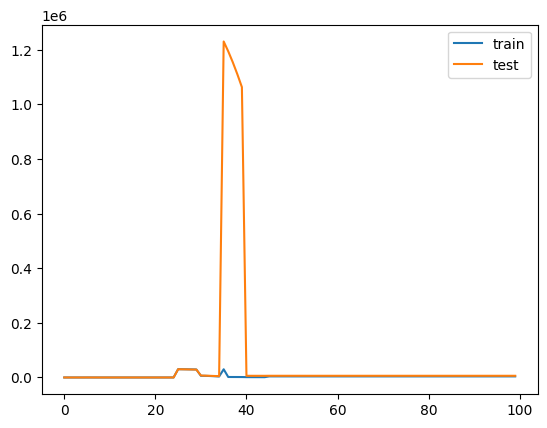

In [54]:
plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')
plt.legend()
plt.show()

In [55]:
lib = ['sqrt']
model.prune()
model.auto_symbolic(lib=lib)
model.symbolic_formula()

fixing (0,0,0) with sqrt, r2=0.917535388231165
fixing (0,0,1) with sqrt, r2=0.9180908718650783
fixing (0,0,2) with sqrt, r2=0.942974390372591
fixing (0,0,3) with sqrt, r2=0.9548610360646217
fixing (0,0,4) with sqrt, r2=0.8367169410661347
fixing (0,1,0) with sqrt, r2=0.6445910861390883
fixing (0,1,1) with sqrt, r2=0.9807236991691809
fixing (0,1,2) with sqrt, r2=0.977705931950135
fixing (0,1,3) with sqrt, r2=0.978326014292258
fixing (0,1,4) with sqrt, r2=0.983487419088044
fixing (0,2,0) with sqrt, r2=0.9995003036872531
fixing (0,2,1) with sqrt, r2=0.9899030349628017
fixing (0,2,2) with sqrt, r2=0.9914904720695717
fixing (0,2,3) with sqrt, r2=0.9789197411374078
fixing (0,2,4) with sqrt, r2=0.9895943970023083
fixing (0,3,0) with sqrt, r2=0.9847701291384038
fixing (0,3,1) with sqrt, r2=0.9925530153715035
fixing (0,3,2) with sqrt, r2=0.9923436686034277
fixing (0,3,3) with sqrt, r2=0.9926403410824165
fixing (0,3,4) with sqrt, r2=0.9925482062604731
fixing (0,4,0) with sqrt, r2=0.99151892666535

KeyboardInterrupt: 

In [ ]:
formula1, formula2= model.symbolic_formula()[0]
formula1, formula2

(1.3354500893916*sqrt(0.606872421981223*(6.283754301981e-7*sqrt(1 - 0.4*x_17) + 6.8286830109608e-7*sqrt(1 - 0.39*x_18) - 7.3006975671042e-8*sqrt(1 - 1.0*x_19) + 1.03182141079438e-5*sqrt(0.02*x_15 + 1) + 7.05346962269014e-8*sqrt(0.35*x_16 + 1) + 1)**(1/4) + 1) + 2.15,
 0.0312086069623889*sqrt(1 - 0.583892743351986*(6.283754301981e-7*sqrt(1 - 0.4*x_17) + 6.8286830109608e-7*sqrt(1 - 0.39*x_18) - 7.3006975671042e-8*sqrt(1 - 1.0*x_19) + 1.03182141079438e-5*sqrt(0.02*x_15 + 1) + 7.05346962269014e-8*sqrt(0.35*x_16 + 1) + 1)**(1/4)) - 2.18)

In [ ]:
variables = [f'x_{i+1}' for i in range(X.shape[1])]  # Generate variable names based on the number of columns in X

# Function to substitute values in the formula dynamically
def substitute_formula(formula, X_row):
    for idx, var in enumerate(variables):
        formula = formula.subs(var, X_row[idx])
    return formula

# Example usage in your accuracy function
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in tqdm(range(batch)):
        logit1 = np.array(substitute_formula(formula1, X[i])).astype(np.float64)
        logit2 = np.array(substitute_formula(formula2, X[i])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct / batch

# print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

print(f'Only predicting zero means: {99884/100000}')

  0%|          | 0/6000 [00:00<?, ?it/s]100%|██████████| 6000/6000 [01:57<00:00, 51.02it/s]

test acc of the formula: tensor(0.9977)
Only predicting zero means: 0.99884


In [56]:
# Function to compute accuracy, precision, recall, and F1 score
def metrics(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    TP = FP = TN = FN = 0
    
    for i in tqdm(range(batch)):
        logit1 = np.array(substitute_formula(formula1, X[i])).astype(np.float64)
        logit2 = np.array(substitute_formula(formula2, X[i])).astype(np.float64)
        prediction = logit2 > logit1
      
        if prediction == bool(y[i]):
            correct += 1
            if prediction == 1:
                TP += 1
            else:
                TN += 1
        else:
            if prediction == 1:
                FP += 1
            else:
                FN += 1

    accuracy = correct / batch
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1_score

# Calculate metrics for train and test sets
# train_metrics = metrics(formula1, formula2, dataset['train_input'], dataset['train_label'])
test_metrics = metrics(formula1, formula2, dataset['test_input'], dataset['test_label'])

# print(f'Train Metrics - Accuracy: {train_metrics[0]:.4f}, Precision: {train_metrics[1]:.4f}, Recall: {train_metrics[2]:.4f}, F1 Score: {train_metrics[3]:.4f}')
print(f'Test Metrics - Accuracy: {test_metrics[0]:.4f}, Precision: {test_metrics[1]:.4f}, Recall: {test_metrics[2]:.4f}, F1 Score: {test_metrics[3]:.4f}')

100%|██████████| 4500/4500 [01:29<00:00, 50.53it/s]

Test Metrics - Accuracy: 0.9976, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


In [136]:
len(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'])

11

In [19]:
plotPerColumnDistribution(df1, 10, 5)

ValueError: Number of rows must be a positive integer, not 1.2

<Figure size 2400x768 with 0 Axes>

Correlation matrix:

In [11]:
plotCorrelationMatrix(df1, 8)

TypeError: DataFrame.dropna() takes 1 positional argument but 2 were given

Scatter and density plots:

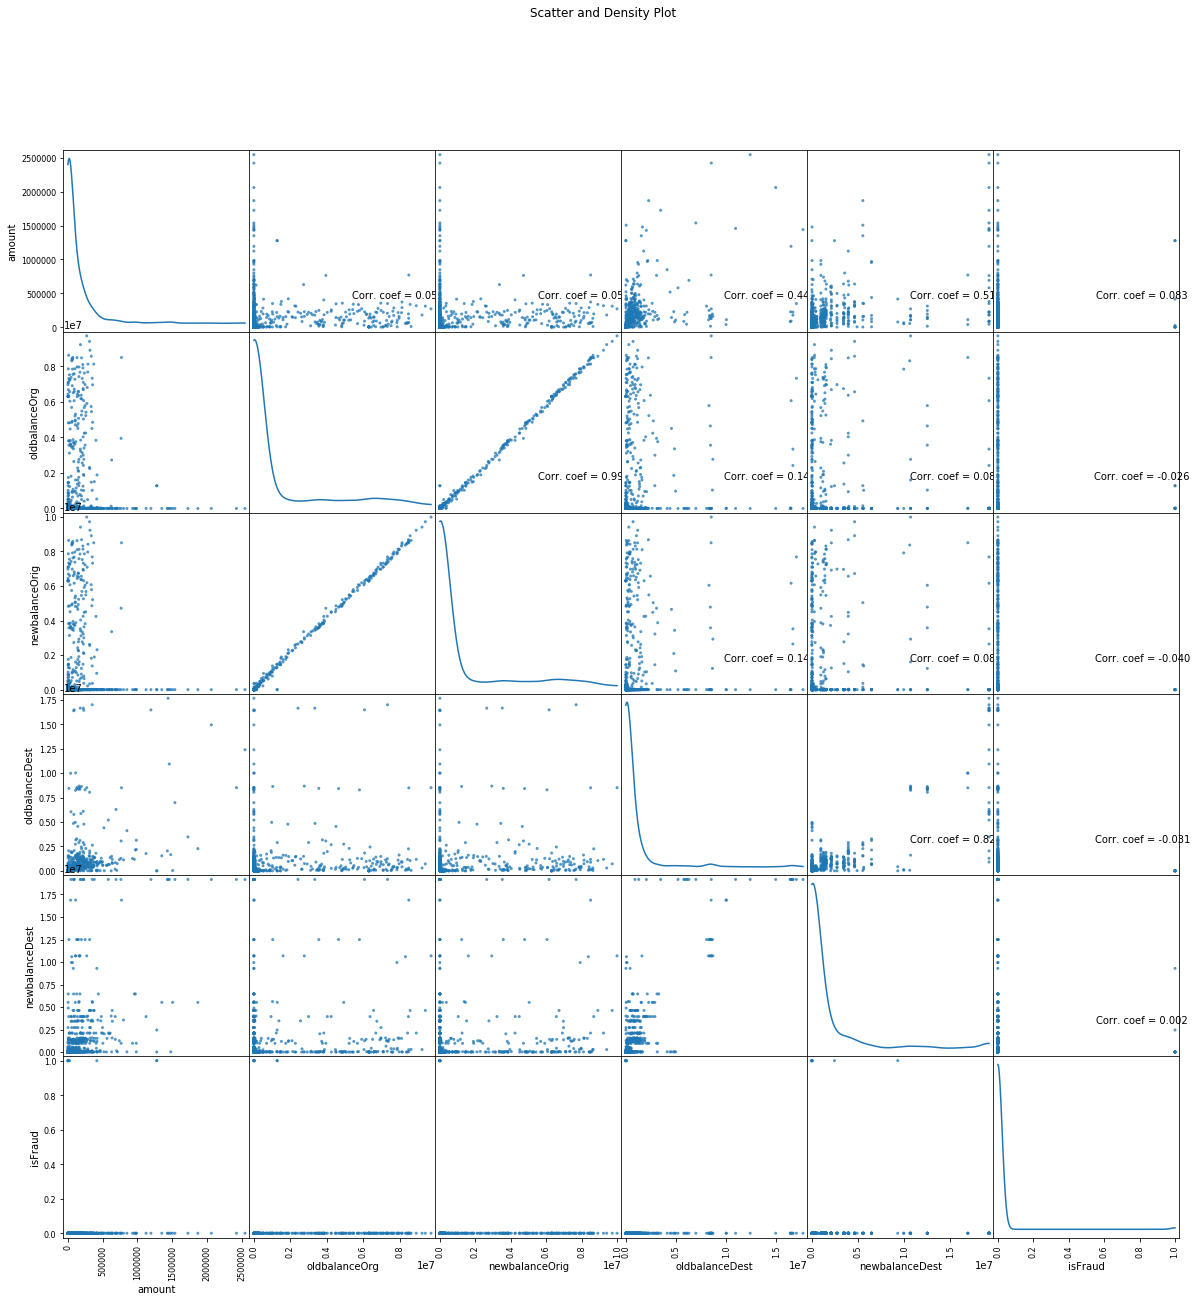

In [10]:
plotScatterMatrix(df1, 20, 10)

## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Edit Notebook" button at the top of the kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!